# Requirements

In [599]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.metrics import f1_score, r2_score, classification_report, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
import missingno as msno
from xgboost import XGBRegressor, XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

# Laboratory Exercise - Run Mode (8 points)

## Mobile Device Usage and User Behavior Dataset
The dataset contains detailed information on 700 mobile device users, capturing various usage patterns and behavior classifications. The features include app usage time, screen-on time, battery drain, data consumption, and more. These metrics provide insights into the user's daily interactions with their device, such as how much time is spent on apps, the amount of screen activity, battery usage, and mobile data consumption. In addition, user demographics like age and gender are included, as well as the device model and operating system. The 'user behavior class' attribute categorizes users based on their usage patterns, ranging from light to extreme behavior. All features, except for the 'user behavior class', can be used as input variables for analysis and modeling, while the 'user behavior class' serves as the target variable for prediction. This dataset offers valuable insights for studying mobile user behavior and can be used for building predictive models in the domain of mobile technology and applications.

Load the dataset into a `pandas` data frame.

In [539]:
df = pd.read_csv('user_behavior_data.csv')

In [540]:
df

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122.0,40.0,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944.0,47.0,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,NaN,42.0,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871.0,20.0,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988.0,31.0,Female,3
...,...,...,...,...,...,...,...,...,...,...,...
695,696,iPhone 12,iOS,92,3.9,1082,26,NaN,22.0,Male,2
696,697,Xiaomi Mi 11,Android,316,6.8,1965,68,NaN,59.0,Male,4
697,698,Google Pixel 5,Android,99,3.1,942,22,457.0,50.0,Female,2
698,699,Samsung Galaxy S21,Android,62,1.7,431,13,224.0,44.0,Male,1


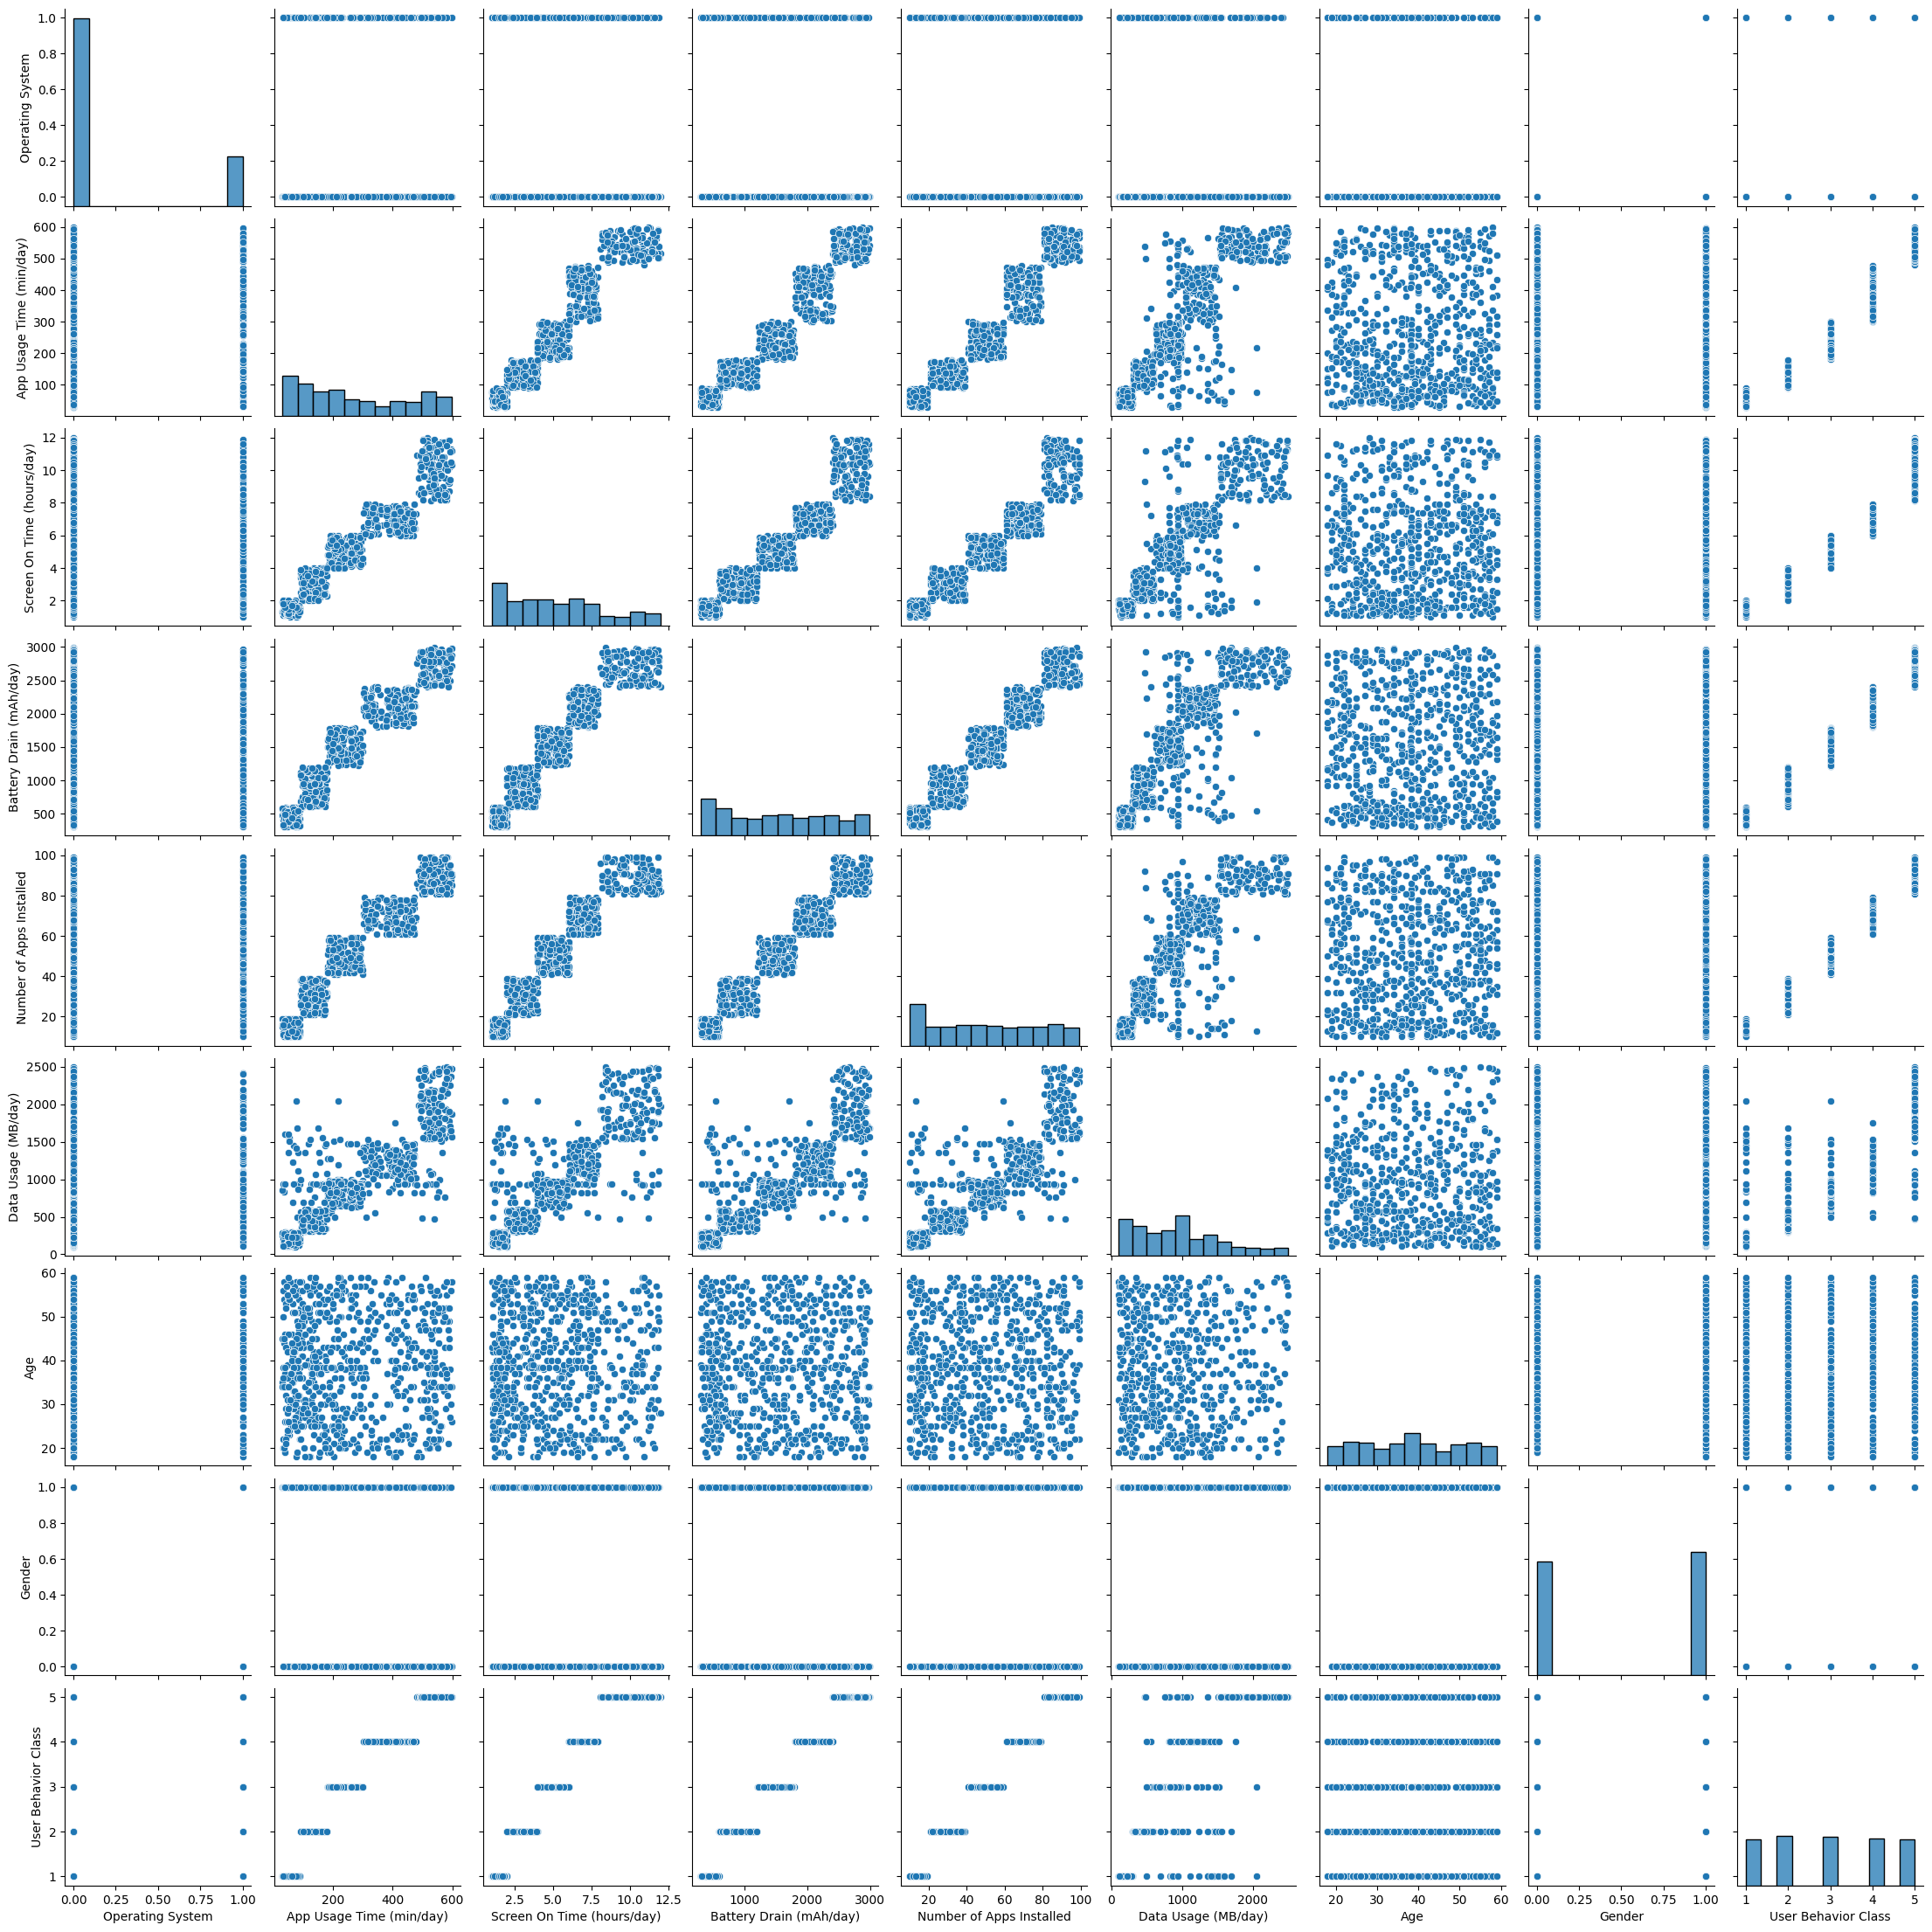

In [598]:
sns.pairplot(df)

In [541]:
df.isnull().sum()

User ID                         0
Device Model                    0
Operating System               70
App Usage Time (min/day)        0
Screen On Time (hours/day)      0
Battery Drain (mAh/day)         0
Number of Apps Installed        0
Data Usage (MB/day)           140
Age                            35
Gender                          0
User Behavior Class             0
dtype: int64

Preprocess the input and the output variables appropriately.

In [542]:
def impute_os(row):
    os_value = row['Operating System']
    device_model = row['Device Model']
    
    if pd.isna(os_value):
        if 'iPhone' in str(device_model):
            return 'iOS'
        else:
            return 'Android'
    
    return os_value

In [543]:
df['Operating System'] = df.apply(impute_os, axis=1)

In [544]:
iphone_rows = df[df['Device Model'].str.contains('iPhone', na=False)]

iphone_rows[['Device Model', 'Operating System']].sample(10)

,Device Model,Operating System
473,iPhone 12,iOS
482,iPhone 12,iOS
487,iPhone 12,iOS
193,iPhone 12,iOS
68,iPhone 12,iOS
234,iPhone 12,iOS
303,iPhone 12,iOS
554,iPhone 12,iOS
484,iPhone 12,iOS
509,iPhone 12,iOS


In [545]:
non_iphone_rows = df[~df['Device Model'].str.contains('iPhone', na=False)]

In [546]:
non_iphone_rows[['Device Model', 'Operating System']].sample(10)

,Device Model,Operating System
516,Xiaomi Mi 11,Android
661,Xiaomi Mi 11,Android
268,Samsung Galaxy S21,Android
156,Xiaomi Mi 11,Android
523,Samsung Galaxy S21,Android
184,Xiaomi Mi 11,Android
688,Google Pixel 5,Android
255,OnePlus 9,Android
249,Google Pixel 5,Android
373,Google Pixel 5,Android


<Axes: xlabel='Device Model'>

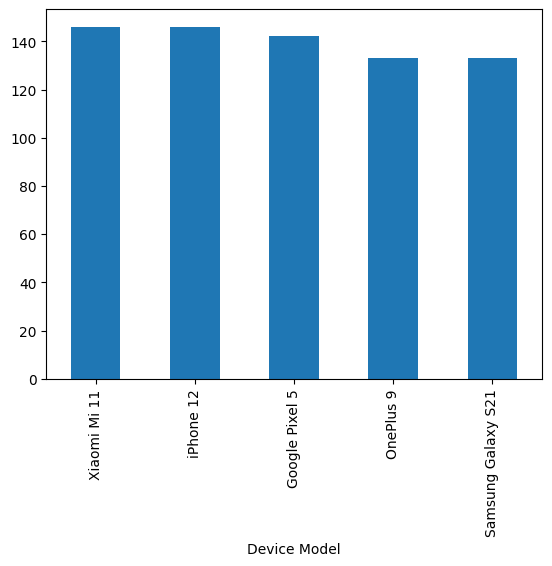

In [547]:
df['Device Model'].value_counts().plot.bar()

In [548]:
df.drop('User ID', axis=1, inplace=True)

In [550]:
df.drop('Device Model', axis=1, inplace=True)

In [551]:
df

,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,Android,393,6.4,1872,67,1122.0,40.0,Male,4
1,Android,268,4.7,1331,42,944.0,47.0,Female,3
2,Android,154,4.0,761,32,NaN,42.0,Male,2
3,Android,239,4.8,1676,56,871.0,20.0,Male,3
4,iOS,187,4.3,1367,58,988.0,31.0,Female,3
...,...,...,...,...,...,...,...,...,...
695,iOS,92,3.9,1082,26,NaN,22.0,Male,2
696,Android,316,6.8,1965,68,NaN,59.0,Male,4
697,Android,99,3.1,942,22,457.0,50.0,Female,2
698,Android,62,1.7,431,13,224.0,44.0,Male,1


In [552]:
encoder = LabelEncoder()

In [553]:
df['Operating System'] = encoder.fit_transform(df['Operating System'])
df['Gender'] = encoder.fit_transform(df['Gender'])

In [554]:
df

,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,0,393,6.4,1872,67,1122.0,40.0,1,4
1,0,268,4.7,1331,42,944.0,47.0,0,3
2,0,154,4.0,761,32,NaN,42.0,1,2
3,0,239,4.8,1676,56,871.0,20.0,1,3
4,1,187,4.3,1367,58,988.0,31.0,0,3
...,...,...,...,...,...,...,...,...,...
695,1,92,3.9,1082,26,NaN,22.0,1,2
696,0,316,6.8,1965,68,NaN,59.0,1,4
697,0,99,3.1,942,22,457.0,50.0,0,2
698,0,62,1.7,431,13,224.0,44.0,1,1


Explore the dataset using visualizations of your choice.

array([[<Axes: title={'center': 'Operating System'}>,
        <Axes: title={'center': 'App Usage Time (min/day)'}>,
        <Axes: title={'center': 'Screen On Time (hours/day)'}>],
       [<Axes: title={'center': 'Battery Drain (mAh/day)'}>,
        <Axes: title={'center': 'Number of Apps Installed'}>,
        <Axes: title={'center': 'Data Usage (MB/day)'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'User Behavior Class'}>]], dtype=object)

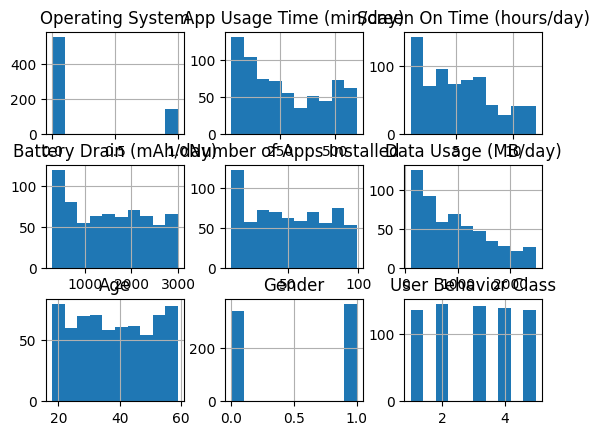

In [555]:
df.hist()

<Axes: >

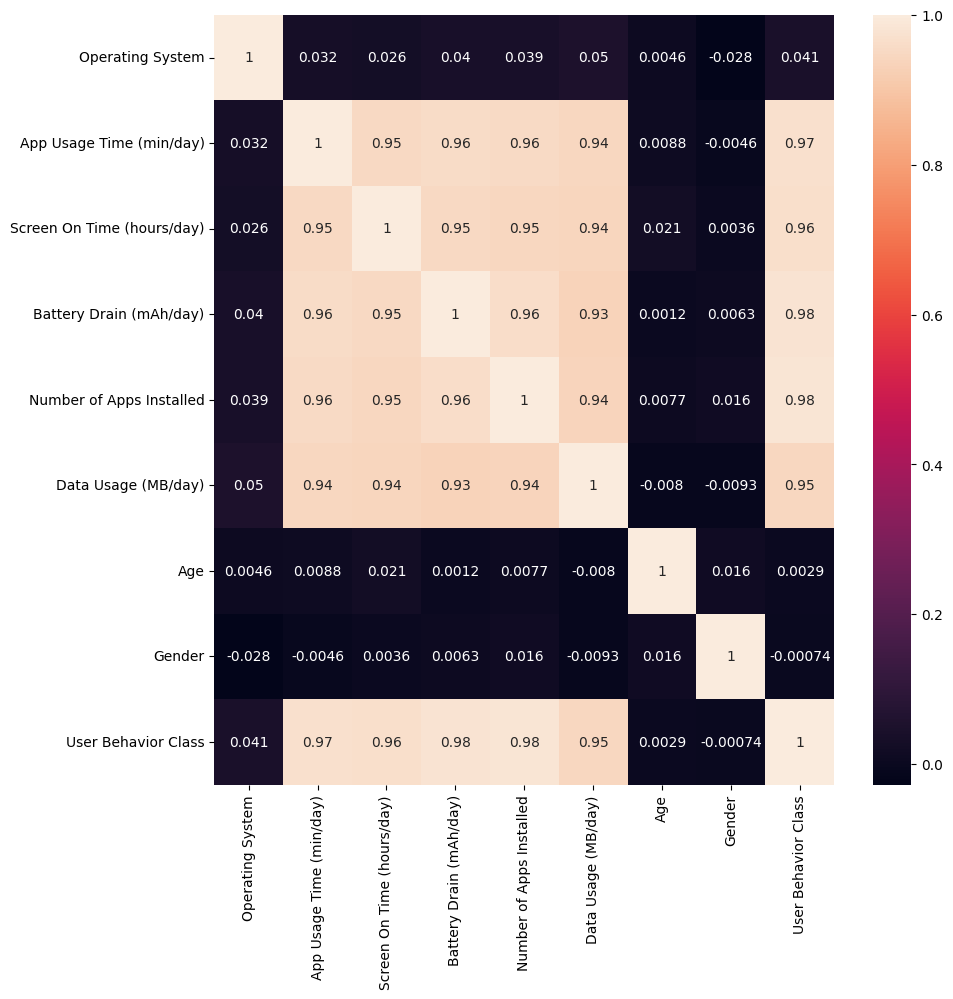

In [556]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)

Check if the dataset is balanced.

<Axes: xlabel='User Behavior Class'>

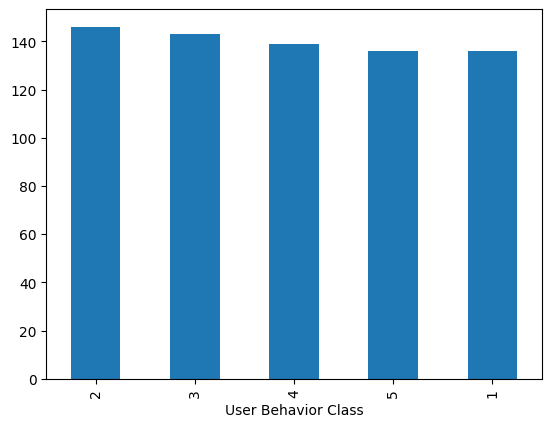

In [557]:
df['User Behavior Class'].value_counts().plot.bar()

<Axes: xlabel='Operating System'>

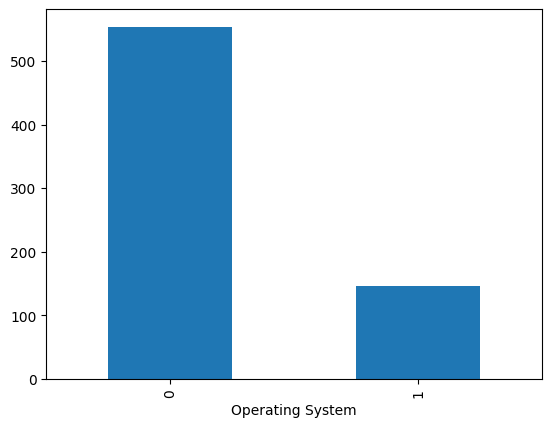

In [380]:
df['Operating System'].value_counts().plot.bar()

## Detecting Missing Values
Calculate the percentage of missing values present in each column of the dataset.

In [558]:
df.isnull().sum()

Operating System                0
App Usage Time (min/day)        0
Screen On Time (hours/day)      0
Battery Drain (mAh/day)         0
Number of Apps Installed        0
Data Usage (MB/day)           140
Age                            35
Gender                          0
User Behavior Class             0
dtype: int64

In [559]:
missing_percent = df.isnull().sum() / len(df) * 100
missing_percent

Operating System               0.0
App Usage Time (min/day)       0.0
Screen On Time (hours/day)     0.0
Battery Drain (mAh/day)        0.0
Number of Apps Installed       0.0
Data Usage (MB/day)           20.0
Age                            5.0
Gender                         0.0
User Behavior Class            0.0
dtype: float64

## Understanding the Causes Behind Missing Values
Using visualization tools such as heatmaps, and dendrograms, illustrate the interdependence between attributes with missing values. Also, visualize the distribution of the missing values within the dataset using matrices and bar charts.

<Axes: >

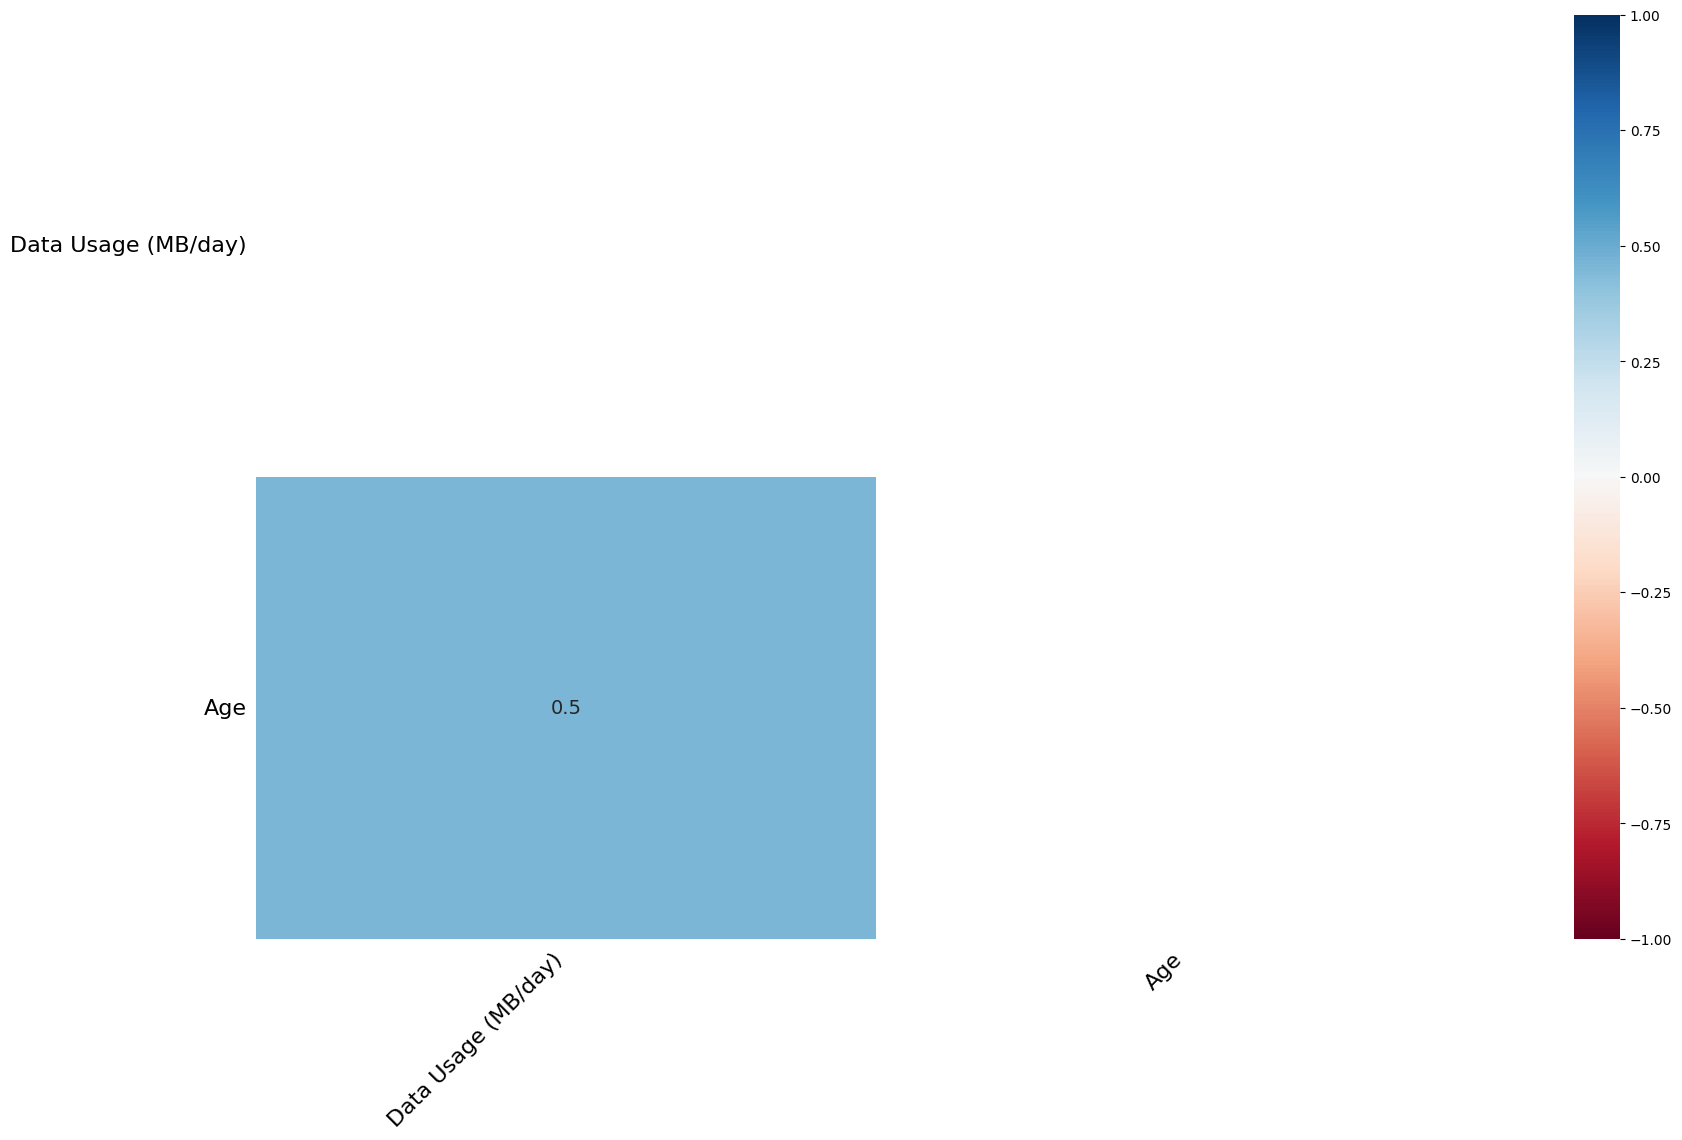

In [560]:
msno.heatmap(df)

<Axes: >

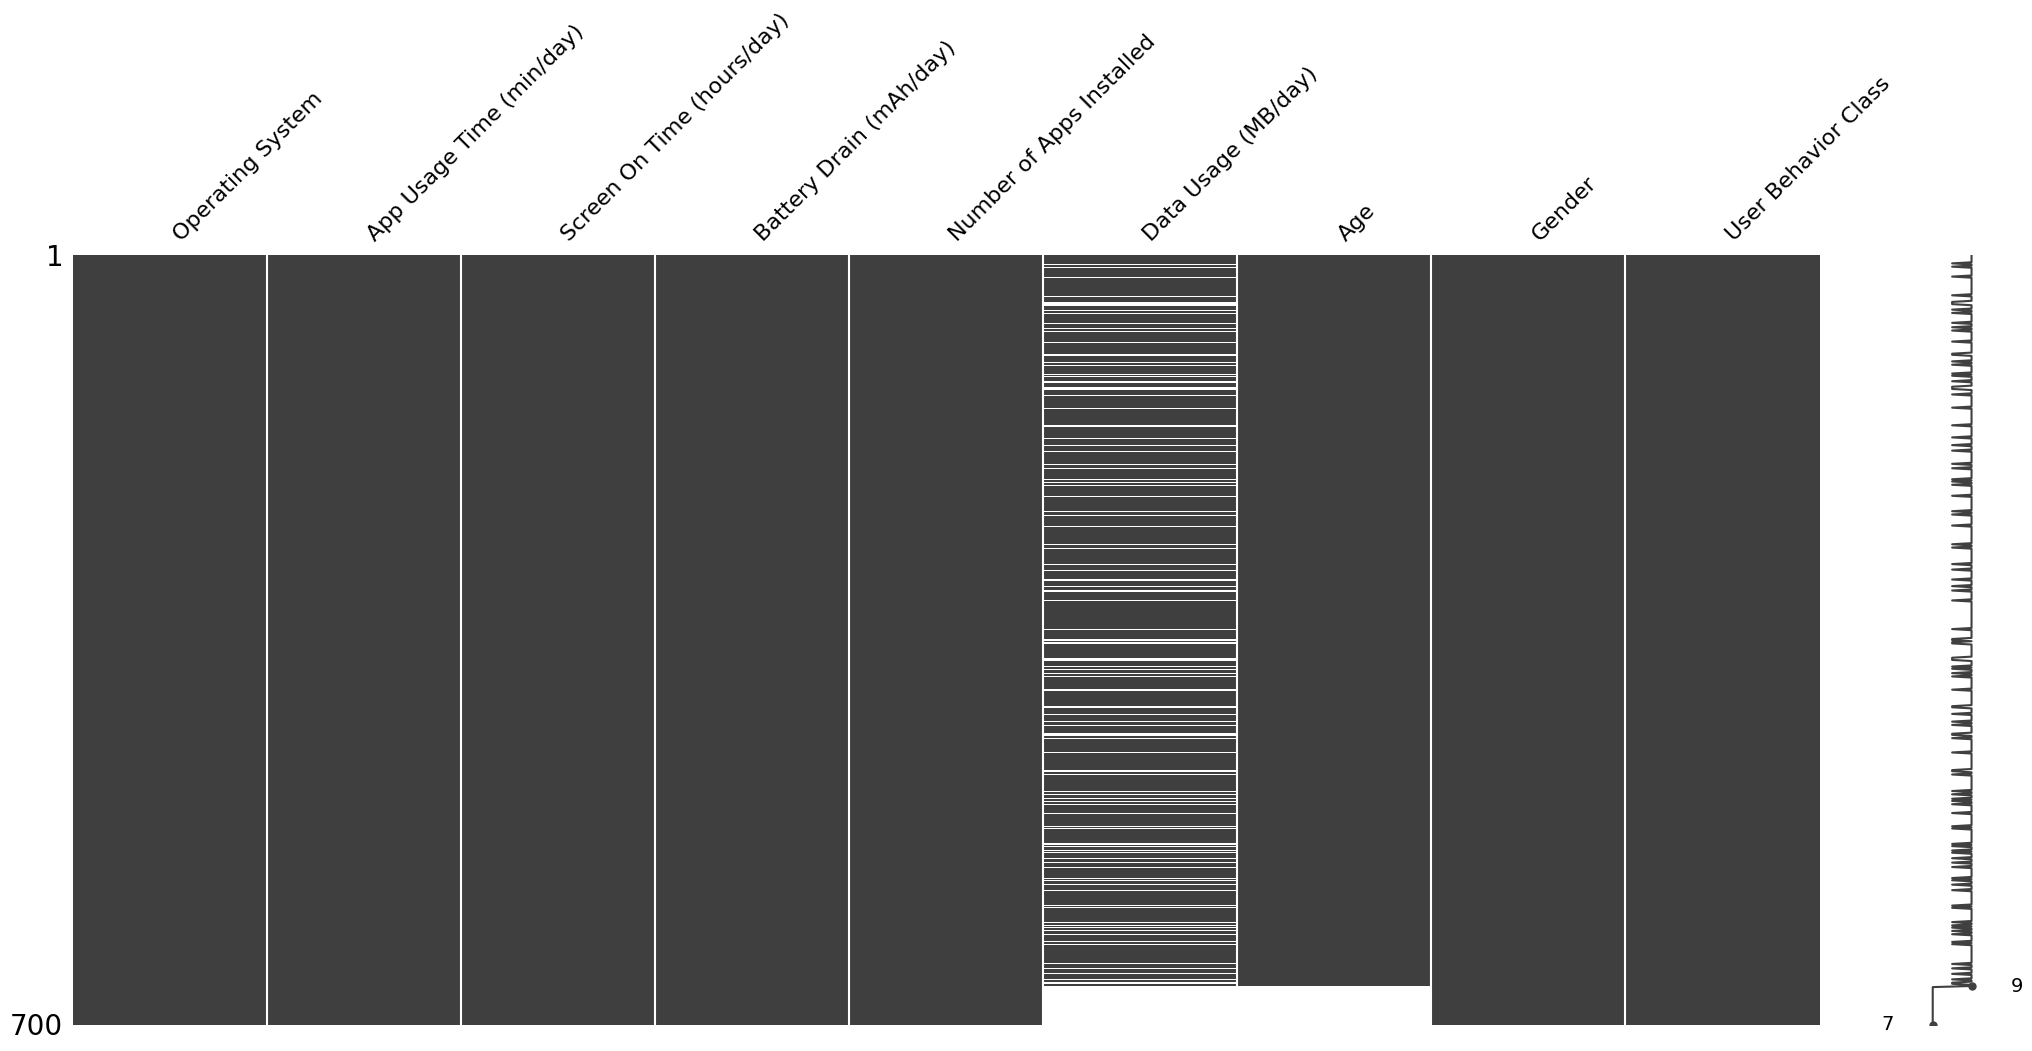

In [561]:
msno.matrix(df.sort_values('Age'))

## Handling the Missing Values
Handle the missing values using suitable method based on the insights obtained from the various visualizations.

In [562]:
df

,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,0,393,6.4,1872,67,1122.0,40.0,1,4
1,0,268,4.7,1331,42,944.0,47.0,0,3
2,0,154,4.0,761,32,NaN,42.0,1,2
3,0,239,4.8,1676,56,871.0,20.0,1,3
4,1,187,4.3,1367,58,988.0,31.0,0,3
...,...,...,...,...,...,...,...,...,...
695,1,92,3.9,1082,26,NaN,22.0,1,2
696,0,316,6.8,1965,68,NaN,59.0,1,4
697,0,99,3.1,942,22,457.0,50.0,0,2
698,0,62,1.7,431,13,224.0,44.0,1,1


In [563]:
scaler = MinMaxScaler()
sacled_data = scaler.fit_transform(df[['Data Usage (MB/day)', 'Age']])

In [564]:
imputer = KNNImputer(n_neighbors=3)
imputed_data = imputer.fit_transform(sacled_data)

In [565]:
imputed_data = scaler.inverse_transform(imputed_data)

In [566]:
df[['Data Usage (MB/day)', 'Age']] = imputed_data

In [567]:
df

,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,0,393,6.4,1872,67,1122.000000,40.0,1,4
1,0,268,4.7,1331,42,944.000000,47.0,0,3
2,0,154,4.0,761,32,1233.333333,42.0,1,2
3,0,239,4.8,1676,56,871.000000,20.0,1,3
4,1,187,4.3,1367,58,988.000000,31.0,0,3
...,...,...,...,...,...,...,...,...,...
695,1,92,3.9,1082,26,1000.000000,22.0,1,2
696,0,316,6.8,1965,68,1525.333333,59.0,1,4
697,0,99,3.1,942,22,457.000000,50.0,0,2
698,0,62,1.7,431,13,224.000000,44.0,1,1


<Axes: ylabel='Frequency'>

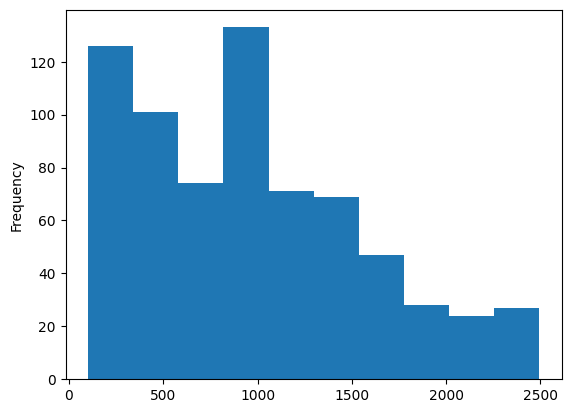

In [517]:
df['Data Usage (MB/day)'].plot.hist()

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

In [568]:
target = 'User Behavior Class'
X = df.drop(target, axis=1)
Y = df[target]

In [571]:
Y

0      4
1      3
2      2
3      3
4      3
      ..
695    2
696    4
697    2
698    1
699    3
Name: User Behavior Class, Length: 700, dtype: int64

In [572]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Feature Scaling
Standardize the features appropriately.

## Model Selection

Choose and train an approriate model for the given task.

In [579]:
model = DecisionTreeClassifier(max_depth=2)
model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=2)

Use the trained model to make predictions for the test set.

In [580]:
y_pred = model.predict(X_test)

Assess the performance of the model by using different classification metrics.

In [581]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        28
           2       0.55      1.00      0.71        34
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        27
           5       1.00      1.00      1.00        26

    accuracy                           0.80       140
   macro avg       0.71      0.80      0.74       140
weighted avg       0.69      0.80      0.73       140



C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [595]:
model = CatBoostClassifier(learning_rate=0.1)
model.fit(X_train, Y_train)

0:	learn: 1.3240243	total: 16.9ms	remaining: 16.9s
1:	learn: 1.1353399	total: 30.4ms	remaining: 15.2s
2:	learn: 0.9771429	total: 39.5ms	remaining: 13.1s
3:	learn: 0.8444473	total: 47.6ms	remaining: 11.8s
4:	learn: 0.7397742	total: 55.9ms	remaining: 11.1s
5:	learn: 0.6580821	total: 62.1ms	remaining: 10.3s
6:	learn: 0.5933318	total: 73.2ms	remaining: 10.4s
7:	learn: 0.5272701	total: 82.9ms	remaining: 10.3s
8:	learn: 0.4731467	total: 94.6ms	remaining: 10.4s
9:	learn: 0.4254145	total: 102ms	remaining: 10.1s
10:	learn: 0.3859407	total: 109ms	remaining: 9.78s
11:	learn: 0.3478173	total: 115ms	remaining: 9.45s
12:	learn: 0.3168288	total: 122ms	remaining: 9.26s
13:	learn: 0.2874872	total: 139ms	remaining: 9.82s
14:	learn: 0.2609840	total: 145ms	remaining: 9.53s
15:	learn: 0.2376308	total: 152ms	remaining: 9.36s
16:	learn: 0.2172446	total: 157ms	remaining: 9.11s
17:	learn: 0.2006574	total: 163ms	remaining: 8.88s
18:	learn: 0.1836576	total: 169ms	remaining: 8.73s
19:	learn: 0.1701064	total: 174m

In [596]:
y_pred = model.predict(X_test)

In [597]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        11

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



In [600]:
model = LogisticRegression()
model.fit(X_train, Y_train)

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [601]:
y_pred = model.predict(X_test)

In [602]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           1       0.92      0.92      0.92        13
           2       0.71      0.67      0.69        15
           3       0.60      0.50      0.55        18
           4       0.29      0.31      0.30        13
           5       0.57      0.73      0.64        11

    accuracy                           0.61        70
   macro avg       0.62      0.62      0.62        70
weighted avg       0.62      0.61      0.62        70



# Laboratory Exercise - Bonus Task (+ 2 points)

As part of the bonus task in this laboratory assignment, your objective is to fine-tune at least one hyper-parameter using a cross-validation with grid search. This involves systematically experimenting with various values for the hyper-parameter(s) and evaluating the model's performance using cross-validation. Upon determining the most suitable value(s) for the hyper-parameter(s), evaluate the model's performance on a test set for final assessment.

Hint: Use the `GridCVSearch` from the `scikit-learn` library. Check the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html.

## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

In [606]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

## Feature Scaling
Standardize the features appropriately.

In [583]:
rkf = RepeatedKFold(n_splits=5)
rkf.get_n_splits(X, Y)

50

## Fine-tuning the Hyperparameters
Experiment with various values for the chosen hyperparameter(s) and evaluate the model's performance using cross-validation.

In [618]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_iter': [5, 10, 15, 20]
}

model = LogisticRegression()

cv = GridSearchCV(estimator=model, param_grid=param_grid, cv=rkf)
cv.fit(X_train, Y_train)

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

GridSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=None),
             estimator=LogisticRegression(),
             param_grid={'max_iter': [5, 10, 15, 20]})

## Final Assessment of the Model Performance
Upon determining the most suitable hyperparameter(s), evaluate the model's performance on a test set for final assessment.

In [619]:
cv.best_score_

0.37301587301587297

In [620]:
model = cv.best_estimator_

In [621]:
y_pred = model.predict(X_test)

In [622]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           1       0.86      0.46      0.60        13
           2       0.60      0.19      0.29        16
           3       0.38      0.71      0.50        14
           4       0.44      0.40      0.42        10
           5       0.61      0.82      0.70        17

    accuracy                           0.53        70
   macro avg       0.58      0.52      0.50        70
weighted avg       0.58      0.53      0.51        70

